#### Import libraries and packages

In [1]:
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np
import seaborn as sns

#### Set connection with postgres database

In [2]:
host = 'postgresfib.fib.upc.edu'
dbname = 'ADSDBjordi.cluet'
user = 'jordi.cluet'
pwd = 'DB151199'
port = 6433
sslmode = 'require'

conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, user, pwd))
cursor = conn.cursor()

#### Select whole table as dataframe

In [3]:
sql = "SELECT * from formatted_zone.ajunt_crime_2020_21_12_06;"
df = pd.read_sql_query(sql, conn)
df

,districte,furt,estafes,danys,rob_viol_intim,rob_en_vehicle,rob_força,lesions,aprop_indeg,amenaces,...,agressio_sex,conviv_veinal,vigilancia_poli,molesties_espai_pub,contra_prop_priv,incendis,estupefaents,agressions,proves_alcohol,proves_droga
0,Ciutat Vella,11827,1209,1110,2174,915,866,754,1493,415,...,43,7645,10703,6353,4089,444,1117,601,3520,278
1,L'Eixample,14157,3390,1714,1761,1484,1543,722,833,401,...,32,11474,4721,4445,2178,793,451,477,3770,326
2,Sants-Montjuïc,5605,2024,1268,1050,1075,958,689,401,456,...,16,6783,2933,4477,1250,458,265,353,4286,738
3,Les Corts,2489,999,478,379,457,367,132,118,101,...,3,2030,1405,1394,369,150,55,93,1379,65
4,Sarrià-Sant Gervasi,2441,1822,792,590,589,757,191,137,120,...,11,4842,2641,2318,462,302,139,151,4195,291
5,Gràcia,1977,1369,643,291,475,423,180,111,105,...,7,4512,3488,2512,442,281,103,153,2092,119
6,Horta-Guinardó,2119,1528,1039,568,755,547,379,84,271,...,24,4784,3062,2827,663,349,195,262,1568,106
7,Nou Barris,2565,1500,777,615,605,481,477,107,338,...,24,5281,2385,3955,664,403,273,369,1589,124
8,Sant Andreu,4026,1472,1020,662,529,508,392,130,269,...,16,4020,3284,2456,781,366,199,264,1630,125
9,Sant Martí,7023,2378,1813,1592,1493,913,578,320,392,...,23,6456,4827,5721,1570,696,325,392,5857,416


#### Quality analysis

In [4]:
df.isna().any().any()

False

Assign a colour to each specific district for the barplots

In [5]:
distr = df.districte.unique()
colours = [ "red", "blue", "green", "yellow", "purple", "orange", "gray", "black", 'brown', 'teal']

zip_iterator = zip(distr, colours) 
palette = dict(zip_iterator)

<AxesSubplot:xlabel='furt', ylabel='districte'>

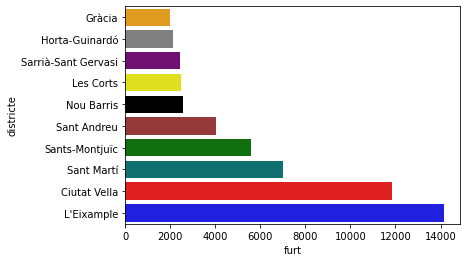

In [8]:
sns.barplot(x='furt', y='districte', data=df, orient='h', palette = palette, order=df.groupby(["districte"])["furt"].max().sort_values().index)

<AxesSubplot:xlabel='estafes', ylabel='districte'>

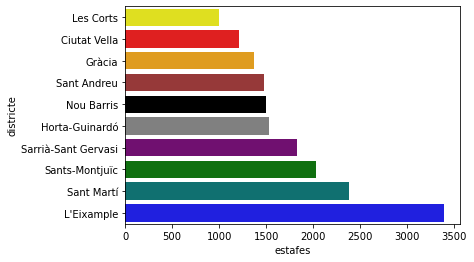

In [9]:
sns.barplot(x='estafes', y='districte', data=df, orient='h', palette = palette, order=df.groupby(["districte"])["estafes"].max().sort_values().index)

<AxesSubplot:xlabel='danys', ylabel='districte'>

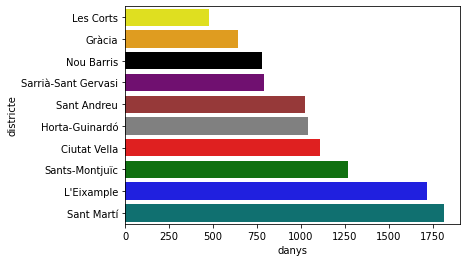

In [10]:
sns.barplot(x='danys', y='districte', data=df, orient='h', palette = palette, order=df.groupby(["districte"])["danys"].max().sort_values().index)

<AxesSubplot:xlabel='incendis', ylabel='districte'>

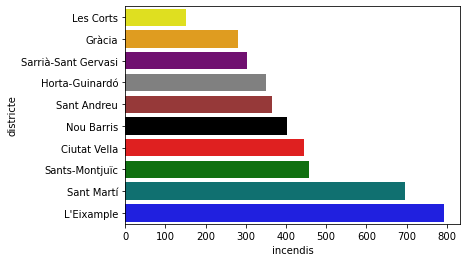

In [11]:
sns.barplot(x='incendis', y='districte', data=df, orient='h', palette = palette, order=df.groupby(["districte"])["incendis"].max().sort_values().index)

This plots could be much better for comparing the districts if its population and/or surface was taken into account (since, for example, Eixample has much more population than Les Corts). Therefore, we leave the analysis for following steps in the pipeline, where we will add these data.

Note, however, that the content of the file does not seem to contain errors nor missing values.

### Load crime table into trusted zone

##### Create trusted_zone schema if it does not exist

In [12]:
create_trusted_zone = """CREATE SCHEMA IF NOT EXISTS trusted_zone;"""
cursor.execute(create_trusted_zone)
conn.commit()

##### Create new table in PostgreSQL database

In [13]:
sqlCreateTable = """CREATE TABLE IF NOT EXISTS trusted_zone.ajunt_crime_2020_21_12_06 (
    DISTRICTE VARCHAR(50),
    FURT INTEGER,
    ESTAFES INTEGER,
    DANYS INTEGER,
    ROB_VIOL_INTIM INTEGER,
    ROB_EN_VEHICLE INTEGER,
    ROB_FORÇA INTEGER,
    LESIONS INTEGER,
    APROP_INDEG INTEGER,
    AMENACES INTEGER,
    ROB_DE_VEHICLE INTEGER,
    OCUPACIONS INTEGER,
    SALUT_PUB INTEGER,
    ABUSOS_SEX INTEGER,
    ENTRADA_DOMICILI INTEGER,
    AGRESSIO_SEX INTEGER,
    CONVIV_VEINAL INTEGER,
    VIGILANCIA_POLI INTEGER,
    MOLESTIES_ESPAI_PUB INTEGER,
    CONTRA_PROP_PRIV INTEGER,
    INCENDIS INTEGER,
    ESTUPEFAENTS INTEGER,
    AGRESSIONS INTEGER,
    PROVES_ALCOHOL INTEGER,
    PROVES_DROGA INTEGER
);"""
cursor.execute(sqlCreateTable)
conn.commit()

##### Insert rows into table

In [14]:
def execute_values(conn, df, table):
  
    tuples = [tuple(x) for x in df.to_numpy()]
  
    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("The dataframe was correctly inserted")
    cursor.close()

In [15]:
execute_values(conn, df, 'trusted_zone.ajunt_crime_2020_21_12_06')

The dataframe was correctly inserted


##### Check correct insertion

In [16]:
sql = "SELECT * from trusted_zone.ajunt_crime_2020_21_12_06;"
pd.read_sql_query(sql, conn)

,districte,furt,estafes,danys,rob_viol_intim,rob_en_vehicle,rob_força,lesions,aprop_indeg,amenaces,...,agressio_sex,conviv_veinal,vigilancia_poli,molesties_espai_pub,contra_prop_priv,incendis,estupefaents,agressions,proves_alcohol,proves_droga
0,Ciutat Vella,11827,1209,1110,2174,915,866,754,1493,415,...,43,7645,10703,6353,4089,444,1117,601,3520,278
1,L'Eixample,14157,3390,1714,1761,1484,1543,722,833,401,...,32,11474,4721,4445,2178,793,451,477,3770,326
2,Sants-Montjuïc,5605,2024,1268,1050,1075,958,689,401,456,...,16,6783,2933,4477,1250,458,265,353,4286,738
3,Les Corts,2489,999,478,379,457,367,132,118,101,...,3,2030,1405,1394,369,150,55,93,1379,65
4,Sarrià-Sant Gervasi,2441,1822,792,590,589,757,191,137,120,...,11,4842,2641,2318,462,302,139,151,4195,291
5,Gràcia,1977,1369,643,291,475,423,180,111,105,...,7,4512,3488,2512,442,281,103,153,2092,119
6,Horta-Guinardó,2119,1528,1039,568,755,547,379,84,271,...,24,4784,3062,2827,663,349,195,262,1568,106
7,Nou Barris,2565,1500,777,615,605,481,477,107,338,...,24,5281,2385,3955,664,403,273,369,1589,124
8,Sant Andreu,4026,1472,1020,662,529,508,392,130,269,...,16,4020,3284,2456,781,366,199,264,1630,125
9,Sant Martí,7023,2378,1813,1592,1493,913,578,320,392,...,23,6456,4827,5721,1570,696,325,392,5857,416
